In [2]:
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
from PIL import Image as im
from sklearn.cluster import SpectralClustering
from collections import Counter

In [3]:
BLOCK_SIZE = 15
SEARCH_BLOCK_WINDOW = 60
SEARCH_BLOCK_SIZE = 56

FOCAL_LENGTH = 0.0069 #m
T = 0.04 #m

In [4]:
def sum_of_abs_diff(pixel_vals_1, pixel_vals_2):
    """
    Args:
        pixel_vals_1 (numpy.ndarray): pixel block from left image
        pixel_vals_2 (numpy.ndarray): pixel block from right image

    Returns:
        float: Sum of absolute difference between individual pixels
    """
    if pixel_vals_1.shape != pixel_vals_2.shape:
        return -1

    return np.sum(abs(pixel_vals_1 - pixel_vals_2))

def sum_of_sqr_diff(pixel_vals_1, pixel_vals_2):
    """
    Args:
        pixel_vals_1 (numpy.ndarray): pixel block from left image
        pixel_vals_2 (numpy.ndarray): pixel block from right image

    Returns:
        float: Sum of square difference between individual pixels
    """
    if pixel_vals_1.shape != pixel_vals_2.shape:
        return -1

    return np.sum(pow(abs(pixel_vals_1 - pixel_vals_2),2))


In [5]:
def match_blocks(y, left_block, right_blocks_array):
    first = True
    min_sad = None
    min_block = None
    min_x = 0
    x = 0
    for right_block in right_blocks_array:
        sad = sum_of_abs_diff(left_block, right_block)
        if first:
            min_sad = sad
            min_block = right_block
            min_x = x
            first = False
        else:
            if sad < min_sad:
                min_sad = sad
                min_block = right_block
                min_x = x

        x += 1

    #print("correspondent x: ", min_x)
    return min_block


In [6]:
def calculate_disparity(img_left, img_right):
    cpy_left_image = img_left.copy()
    cpy_right_image = img_right.copy()

    x_max = min(img_left.shape[1], img_right.shape[1])
    y_max = min(img_left.shape[0], img_right.shape[0])

    left_blocks = []
    right_blocks = []

    disparity_map = np.zeros((y_max, x_max))

    for y in range(0, y_max, BLOCK_SIZE):
        sub_left_blocks = []
        sub_right_blocks = []
        for x in range(0, x_max, BLOCK_SIZE):
            left_block = (x, y, x + BLOCK_SIZE, y + BLOCK_SIZE)
            right_block = (x, y, x + BLOCK_SIZE, y + BLOCK_SIZE)
            if left_block[2] <= x_max and left_block[3] <= y_max:
                cpy_left_image = cv2.rectangle(cpy_left_image, (x, y), (x + BLOCK_SIZE, y + BLOCK_SIZE), (0, 255, 0), 1)
                sub_left_blocks.append(left_block)

            if right_block[2] <= x_max and right_block[3] <= y_max:
                cpy_right_image = cv2.rectangle(cpy_right_image, (x, y), (x + BLOCK_SIZE, y + BLOCK_SIZE), (0, 255, 0),
                                                1)
                sub_right_blocks.append(right_block)

        left_blocks.append(sub_left_blocks)
        right_blocks.append(sub_right_blocks)

    #cv2.imwrite("disparity/block-left-" + str(BLOCK_SIZE) + "_" + str(SEARCH_BLOCK_WINDOW) + ".jpg", cpy_left_image)
    #cv2.imwrite("disparity/block-right-" + str(BLOCK_SIZE) + "_" + str(SEARCH_BLOCK_WINDOW) + ".jpg", cpy_right_image)

    for i in tqdm(range(len(left_blocks))):
        j = 0
        for left_block in left_blocks[i]:
            right_image_valid_blocks = []
            for x in range(max(0, j - SEARCH_BLOCK_WINDOW), len(right_blocks[i])):
                if right_blocks[i][x][0] < left_block[2]:
                    right_valid_block = img_right[right_blocks[i][x][0]:right_blocks[i][x][2],
                                                  right_blocks[i][x][1]:right_blocks[i][x][3]]
                    right_image_valid_blocks.append(right_valid_block)

            # print(len(right_valid_blocks))
            left_image_block = img_left[left_block[0]: left_block[2], left_block[1]: left_block[3]]

            right_block = match_blocks(i, left_image_block, right_image_valid_blocks)
            # print(right_block.shape)
            disparity_map[left_block[0]: left_block[2], left_block[1]: left_block[3]] = abs(
                left_image_block - right_block)

            j += 1

        # i += 1

    return disparity_map.astype(np.uint8), cpy_left_image, cpy_right_image

In [7]:
def calculate_point_cloud(disp_map):

    heatmap = cv2.applyColorMap(disp_map, cv2.COLORMAP_HSV)

    heat_h, heat_s, heat_v = cv2.split(heatmap)

    heat_mask_1 = cv2.inRange(heat_h, 0, 50)
    heat_mask_2 = cv2.inRange(heat_h, 130, 200)

    heat_mask = cv2.bitwise_or(heat_mask_1, heat_mask_2)

    heat_mask = cv2.bitwise_not(heat_mask)

    filtered = cv2.bitwise_and(heatmap, heatmap, mask=heat_mask)

    binarized = cv2.threshold(heat_h, 0, 360, cv2.THRESH_OTSU)[1]

    strel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    strelErode = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))

    binarized = cv2.dilate(binarized, strel)
    binarized = cv2.erode(binarized, strelErode)

    heat_binarized = cv2.bitwise_and(heatmap, heatmap, mask=binarized)
    heat_h = cv2.bitwise_and(heat_h, heat_h, mask=binarized)

    disp_map = cv2.bitwise_and(disp_map, disp_map, mask=binarized)
    # disparity_map = cv2.bitwise_and(disparity_map, disparity_map, mask=binarized)

    disparity_map = disp_map

    print("disparity shape ", disparity_map.shape)

    depth_matrix = np.zeros(disparity_map.shape)

    for y in range(len(disparity_map)):
        for x in range(len(disparity_map[y])):
            z = ((FOCAL_LENGTH * T) / max(disparity_map[y][x], 1))
            # z = 1/z
            z = 1 / (z * 1000)
            depth_matrix[y, x] = z

    num_rows, num_cols = depth_matrix.shape

    depth_matrix = np.roll(depth_matrix, shift=int(210), axis=1)

    max_height = np.max(depth_matrix)

    print("max height: ", max_height)

    # depth_matrix = max_height - depth_matrix

    points_cloud = [(j, i, max_height - depth_matrix[i, j]) for i in range(0, num_rows, 2) for j in
                    range(0, num_cols, 2) if depth_matrix[i, j] > 100]  #


    return points_cloud, heatmap, heat_binarized

In [8]:
def plot_cloud(points_cloud, elev=None, azim=None, roll=None):
    x, y, z = zip(*points_cloud)

    #plt.scatter(x, y, c=z, cmap='inferno', s=10)

    triang = mtri.Triangulation(x, y)

    # VerticesNodesNumbers = vnn
    vnn = triang.triangles
    # print("verticesNodesNumber: ", vnn)
    a, b = vnn.shape
    # print(a)

    area_list = []
    # in order to calculate the area of each single triangle, we need to scan
    # the vnn 2D Array by the number of rows only.

    for i in range(a):
        t1 = (x[vnn[i][0]]) * ((y[vnn[i][1]]) - (y[vnn[i][2]]))
        t2 = (x[vnn[i][1]]) * ((y[vnn[i][2]]) - (y[vnn[i][0]]))
        t3 = (x[vnn[i][2]]) * ((y[vnn[i][0]]) - (y[vnn[i][1]]))
        area_list.append(abs((t1 + t2 + t3) / 2))

    areas = np.array(area_list)

    vnn = [vnn[i] for i in range(a) if areas[i] <= 160]  #

    trig = mtri.Triangulation(x, y, triangles=vnn)

    print("x: ", len(x))
    print("y: ", len(y))
    print("z: ", len(z))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # triangulation
    trisurf = ax.plot_trisurf(trig, z, cmap='viridis', edgecolor='none', antialiased=False);

    fig.colorbar(trisurf, ax=ax, shrink=0.5, aspect=5)

    # point cloud
    # sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=10)

    ax.set_title('Tri-Surface plot')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.view_init(elev=elev, azim=azim, roll=roll)

    plt.show()

In [9]:
def plot_projection(points_cloud, x=0, y=2, c=1):
    xyz = zip(*points_cloud)

    list_xyz = list(xyz)
    
    list_x = list_xyz[x]
    list_y = list_xyz[y]
    list_z = list_xyz[c]

    plt.scatter(list_x, list_y, c=list_z, cmap='inferno', s=10)
    plt.show()

In [10]:
def cluster_points(points_cloud):
    x, y, z = zip(*points_cloud)

    X = np.array([[x[i], y[i], z[i]] for i in range(len(x))])

    print(X.shape)
    model = SpectralClustering(n_clusters=19, random_state=0, affinity='nearest_neighbors',
                               assign_labels='kmeans')
    labels = model.fit_predict(X)
    print(labels)

    cluster_sizes = Counter(labels)
    print(cluster_sizes)

    min_cluster_size = 100  # Adjust as needed

    # Identify clusters with a count below the threshold
    small_clusters = [cluster for cluster, size in cluster_sizes.items() if size < min_cluster_size]
    print("small: ", small_clusters)
    # Remove points belonging to small clusters
    filtered_points = X[~np.isin(labels, small_clusters)]
    
    print(filtered_points.shape)

    # Remove points belonging to small clusters
    labels = labels[~np.isin(labels, small_clusters)]
    # Now 'filtered_points' contains the points you want to keep

    return filtered_points, labels

In [11]:
def plot_3d(points, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=labels, s=50, cmap='viridis')
    plt.show()

In [12]:
left_image = cv2.imread("disparity/test-left.jpg", cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread("disparity/test-right.jpg", cv2.IMREAD_GRAYSCALE)

(-0.5, 602.5, 613.5, -0.5)

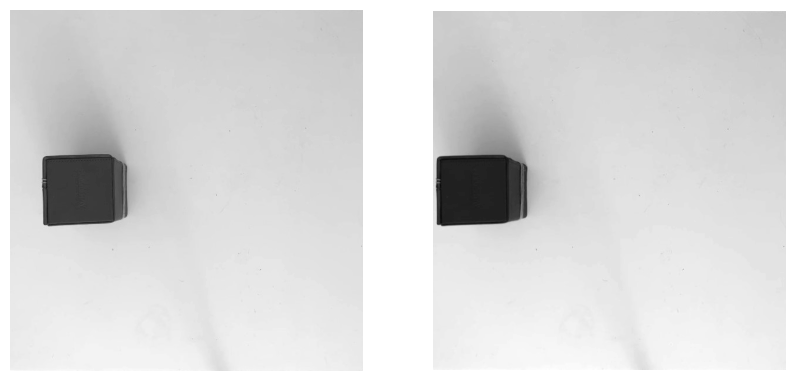

In [13]:
fig = plt.figure(figsize=(10, 7)) 
fig.add_subplot(1, 2, 1)
plt.imshow(left_image, cmap='gray') 
plt.axis('off') 
fig.add_subplot(1, 2, 2)
plt.imshow(right_image, cmap='gray') 
plt.axis('off') 

In [14]:
disparity_map, left_blocked, right_blocked = calculate_disparity(left_image, right_image)

  0%|          | 0/41 [00:00<?, ?it/s]

100%|██████████| 41/41 [00:00<00:00, 160.43it/s]


(-0.5, 602.5, 613.5, -0.5)

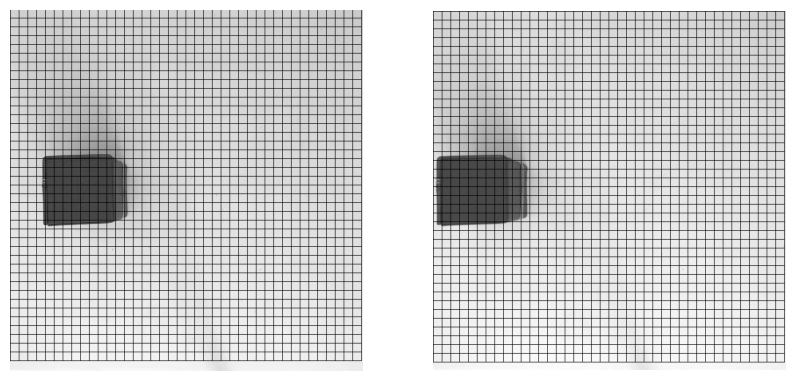

In [15]:
fig = plt.figure(figsize=(10, 7)) 
fig.add_subplot(1, 2, 1)
plt.imshow(left_blocked, cmap='gray') 
plt.axis('off') 
fig.add_subplot(1, 2, 2)
plt.imshow(right_blocked, cmap='gray') 
plt.axis('off') 

In [16]:
#cv2.imwrite("disparity/disparity-map-" + str(BLOCK_SIZE) + "_" + str(SEARCH_BLOCK_WINDOW) + ".jpg", disparity_map)

In [17]:
disp_map = cv2.imread("disparity/disparity-map-" + str(BLOCK_SIZE) + "_" + str(SEARCH_BLOCK_WINDOW) + ".jpg", cv2.IMREAD_GRAYSCALE)

In [18]:
points, heatmap, heat_binarized = calculate_point_cloud(disp_map)

disparity shape  (614, 603)
max height:  923.913043478261


(-0.5, 602.5, 613.5, -0.5)

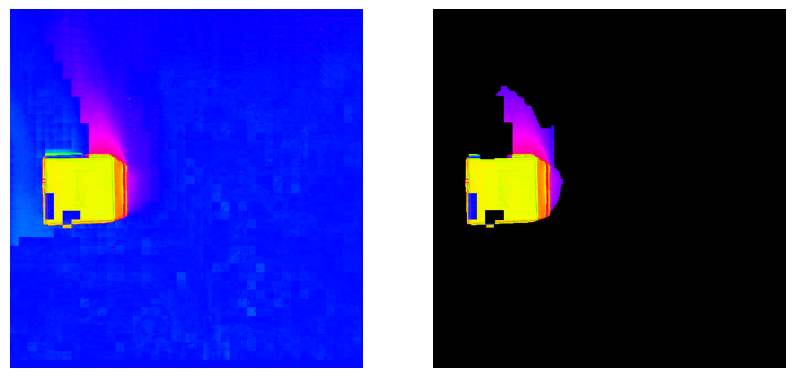

In [19]:
fig = plt.figure(figsize=(10, 7)) 
fig.add_subplot(1, 2, 1)
plt.imshow(heatmap) 
plt.axis('off') 
fig.add_subplot(1, 2, 2)
plt.imshow(heat_binarized) 
plt.axis('off') 

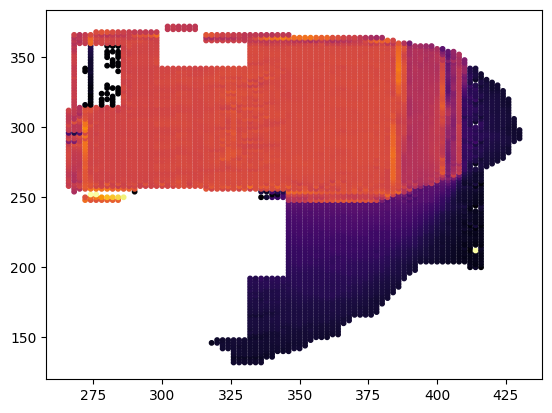

In [20]:
plot_projection(points,0,1,2)

In [21]:
filtered, labels = cluster_points(points)

(5675, 3)
[ 7  7  7 ... 14 14 14]
Counter({5: 745, 16: 534, 13: 490, 4: 483, 3: 437, 15: 394, 1: 360, 18: 353, 0: 326, 2: 296, 6: 286, 8: 235, 11: 196, 14: 178, 7: 137, 12: 110, 17: 55, 9: 41, 10: 19})
small:  [17, 9, 10]
(5560, 3)


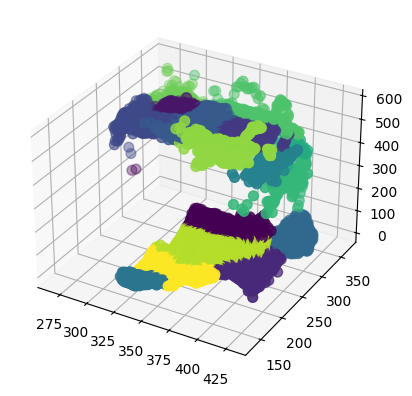

In [22]:
plot_3d(filtered, labels)

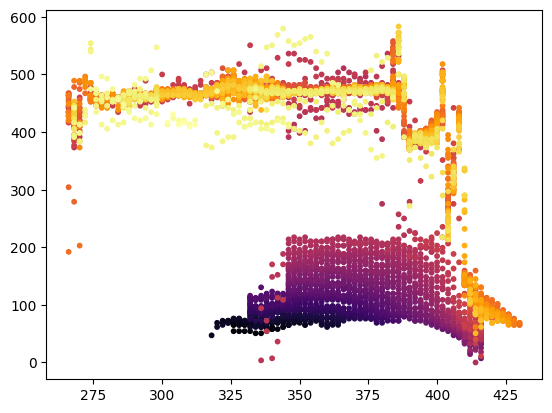

In [23]:
plot_projection(filtered,0,2,1)

x:  5560
y:  5560
z:  5560


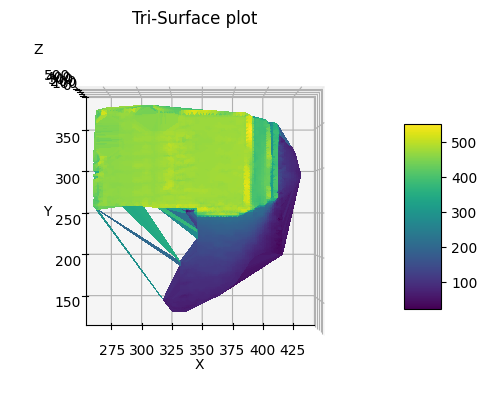

In [24]:
plot_cloud(filtered, 90, -90)

x:  5560
y:  5560
z:  5560


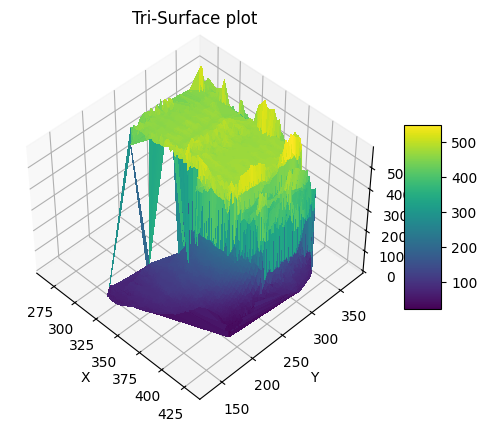

In [26]:
plot_cloud(filtered, 45, -45)